In [32]:
import site
import sys
import pandas as pd 
import numpy as np
import ast 
import matplotlib.pyplot as plt

site.addsitedir('Orion/')
site.addsitedir('MLPrimitives/')

from orion.benchmark import benchmark

In [2]:
BUCKET = 'd3-ai-orion'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

BENCHMARK_DATA = pd.read_csv(S3_URL.format(
    BUCKET, 'datasets.csv'), index_col=0, header=None).applymap(ast.literal_eval).to_dict()[1]

In [8]:
%%capture 
pipelines = ['mssa']

metrics = ['f1', 'accuracy', 'recall', 'precision']

data = {'YAHOOA2': list(BENCHMARK_DATA['YAHOOA2'])}

scores = benchmark(pipelines=pipelines, datasets=data, metrics=metrics, rank='f1')

In [12]:
scores[:50]

,pipeline,rank,f1,accuracy,recall,precision,status,elapsed,split,dataset,signal
0,mssa,1,0.079470,0.902113,0.666667,0.042254,OK,0.028529,False,YAHOOA2,synthetic_56
1,mssa,2,0.079470,0.902113,0.666667,0.042254,OK,0.024981,False,YAHOOA2,synthetic_35
2,mssa,3,0.079470,0.902113,0.666667,0.042254,OK,0.025113,False,YAHOOA2,synthetic_83
3,mssa,4,0.079470,0.902113,0.666667,0.042254,OK,0.028348,False,YAHOOA2,synthetic_98
4,mssa,5,0.079470,0.902113,0.666667,0.042254,OK,0.025953,False,YAHOOA2,synthetic_77
5,mssa,6,0.079470,0.902113,0.666667,0.042254,OK,0.022790,False,YAHOOA2,synthetic_65
6,mssa,7,0.079470,0.902113,0.666667,0.042254,OK,0.024729,False,YAHOOA2,synthetic_86
7,mssa,8,0.079470,0.902113,0.666667,0.042254,OK,0.025754,False,YAHOOA2,synthetic_95
8,mssa,9,0.072000,0.836620,1.000000,0.037344,OK,0.026936,False,YAHOOA2,synthetic_5
9,mssa,10,0.072000,0.836620,1.000000,0.037344,OK,0.026129,False,YAHOOA2,synthetic_80


# Manual mSSA inspection 

In [13]:
from mssa.mssa import mSSA

In [15]:
df = pd.read_csv("datasets/processed/Yahoo/A2Benchmark/synthetic_56.csv")
model = mSSA(rank=2, col_to_row_ratio=1)

In [18]:
model.update_model(df.loc[:,['value']])

In [33]:
df['mssa_pred'] = model.predict("value", df.index[0], df.index[-1])['Mean Predictions']
df['error'] = np.abs(df['value'] - df['mssa_pred'])

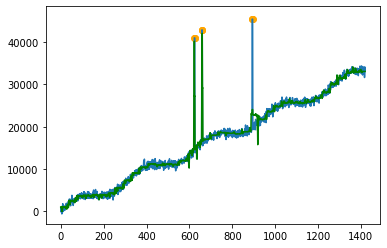

In [29]:
plt.plot(df.index, df.value)
plt.plot(df.index, df.mssa_pred, c="green")
plt.scatter(df.query("is_anomaly == 1").index, df.query("is_anomaly == 1").value, c="orange")

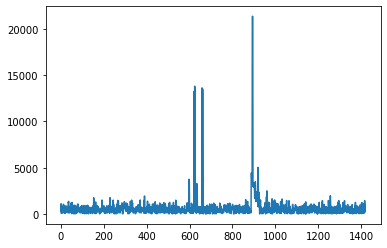

In [34]:
plt.plot(df.index, df.error)
